In [1]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from umap import UMAP

import pickle

In [2]:
from ast import literal_eval

In [3]:
data = pd.read_csv('../data/ext_datasets/data.csv', index_col=0)
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,8,1921,0.4150,60.936,0.9630,1921
1,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",5,1921,0.0366,80.954,0.0594,1921
2,0.996,['John McCormack'],0.518,159507,0.203,0,5uNZnElqOS3W4fRmRYPk4T,0.000000,0,0.115,-10.589,1,The Wearing of the Green,6,1921,0.0615,66.221,0.4060,1921
3,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,1SCWBjhk5WmXPxhDduD3HM,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,0.0594,1921
4,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,4,1921,0.0380,101.665,0.2530,1921


In [4]:
data.shape

(168592, 19)

In [5]:
data.artists = data.artists.apply(lambda x: ' '.join(sorted(literal_eval(x))))

In [6]:
len(data.artists.unique())

32619

In [7]:
audio_features = ['acousticness', 
                 'danceability', 
                 'energy', 
                 'instrumentalness', 
                 'liveness', 
                 'loudness', 
                 'speechiness', 
                 'tempo', 
                 'valence']

In [8]:
artist_audio_features = data.groupby('artists')[audio_features].median()

In [9]:
delta=10e-3
#df.speechiness = (df.speechiness+delta).apply(np.log)
artist_audio_features.instrumentalness = (artist_audio_features.instrumentalness+delta).apply(np.log)

In [10]:
_idx = artist_audio_features.index
_cols = artist_audio_features.columns

In [11]:
scaler = StandardScaler()
artist_audio_features = scaler.fit_transform(artist_audio_features)

In [12]:
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [13]:
artist_audio_features = pd.DataFrame(artist_audio_features, index=_idx, columns=_cols)

In [14]:
artist_play_count = data.groupby('artists').id.count()

In [15]:
artist_audio_features['play_count'] = artist_play_count

In [16]:
artist_play_count.sort_values().describe()

count    32619.000000
mean         5.168521
std         18.359509
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        956.000000
Name: id, dtype: float64

In [17]:
artist_audio_features = artist_audio_features[artist_audio_features.play_count > 2].copy()

In [18]:
artist_audio_features.shape

(9267, 10)

In [19]:
mapper = UMAP(n_neighbors=15)

In [20]:
X = mapper.fit_transform(artist_audio_features[audio_features])
X = pd.DataFrame(X, columns=['x0', 'x1'])
X['artists'] = artist_audio_features.index

In [21]:
X.set_index('artists', inplace=True)

In [22]:
X['play_count'] = artist_audio_features.play_count

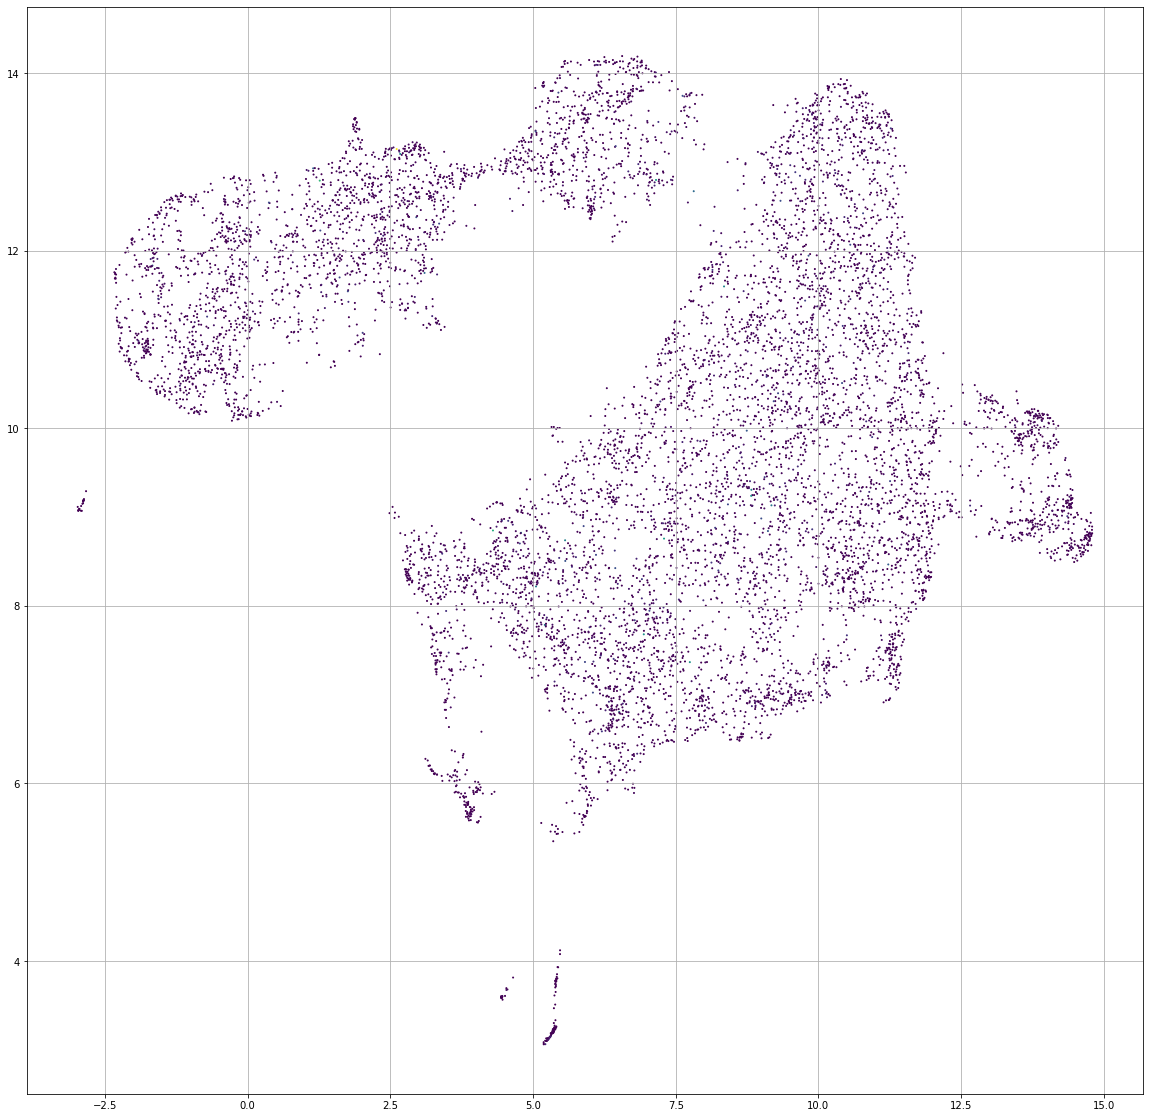

In [23]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.scatter(X.x0, X.x1, s=1, c=X.play_count)
ax.grid(True)

In [25]:
X.to_csv('../data/processed/umap_coords.csv')
with open('../models/mapper.pkl', 'wb') as f:
    pickle.dump(mapper, f)

In [44]:
import matplotlib

In [77]:
hot_cmap = matplotlib.cm.get_cmap('hot')
norm = matplotlib.colors.Normalize(vmin=X.play_count.min(), vmax=X.play_count.max())
hot_rgb = []
for i in X.play_count:
    k = matplotlib.colors.colorConverter.to_rgb(hot_cmap(norm(i)))
    hot_rgb.append(k)

In [78]:
fig = go.Figure(go.Scatter(
                 x=X.x0, 
                 y=X.x1,
                 mode='markers',
                 marker_color=['rgb'+str(c) for c in hot_rgb],
                 text=X.index))
plot(fig)

'temp-plot.html'

In [8]:
tracks = pd.read_csv('../data/processed/tracks.csv', index_col=0)
features = pd.read_csv('../data/processed/track_features.csv', index_col=0)

my_data = pd.merge(tracks, features, on='id')
my_data.played_at = pd.to_datetime(my_data.played_at)
my_data.sort_values('played_at', inplace=True)
my_data.reset_index(inplace=True)
del my_data['index']

In [10]:
my_artist_audio_features = my_data.groupby('artist')[audio_features].median()

In [11]:
delta=10e-3
#df.speechiness = (df.speechiness+delta).apply(np.log)
my_artist_audio_features.instrumentalness = (my_artist_audio_features.instrumentalness+delta).apply(np.log)

_idx = my_artist_audio_features.index
_cols = my_artist_audio_features.columns

with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
my_artist_audio_features = scaler.transform(my_artist_audio_features)

my_artist_audio_features = pd.DataFrame(my_artist_audio_features, index=_idx, columns=_cols)

my_artist_play_count = my_data.groupby('artist').played_at.count()

In [12]:
with open('../models/mapper.pkl', 'rb') as f:
    mapper = pickle.load(f)

In [13]:
X = pd.read_csv('../data/processed/umap_coords.csv', index_col=0)

In [15]:
my_X = mapper.transform(my_artist_audio_features)

In [19]:
my_X = pd.DataFrame(my_X, columns=['x0', 'x1'])
my_X['artists'] = my_artist_audio_features.index
my_X = my_X.set_index('artists')
my_X['play_count'] = my_artist_play_count

In [77]:
hot_cmap = matplotlib.cm.get_cmap('hot')
norm = matplotlib.colors.Normalize(vmin=X.play_count.min(), vmax=X.play_count.max())
hot_rgb = []
for i in X.play_count:
    k = matplotlib.colors.colorConverter.to_rgb(hot_cmap(norm(i)))
    hot_rgb.append(k)

In [78]:
fig = go.Figure(go.Scatter(
                 x=X.x0, 
                 y=X.x1,
                 mode='markers',
                 marker_color=['rgb'+str(c) for c in hot_rgb],
                 text=X.index))
plot(fig)

'temp-plot.html'

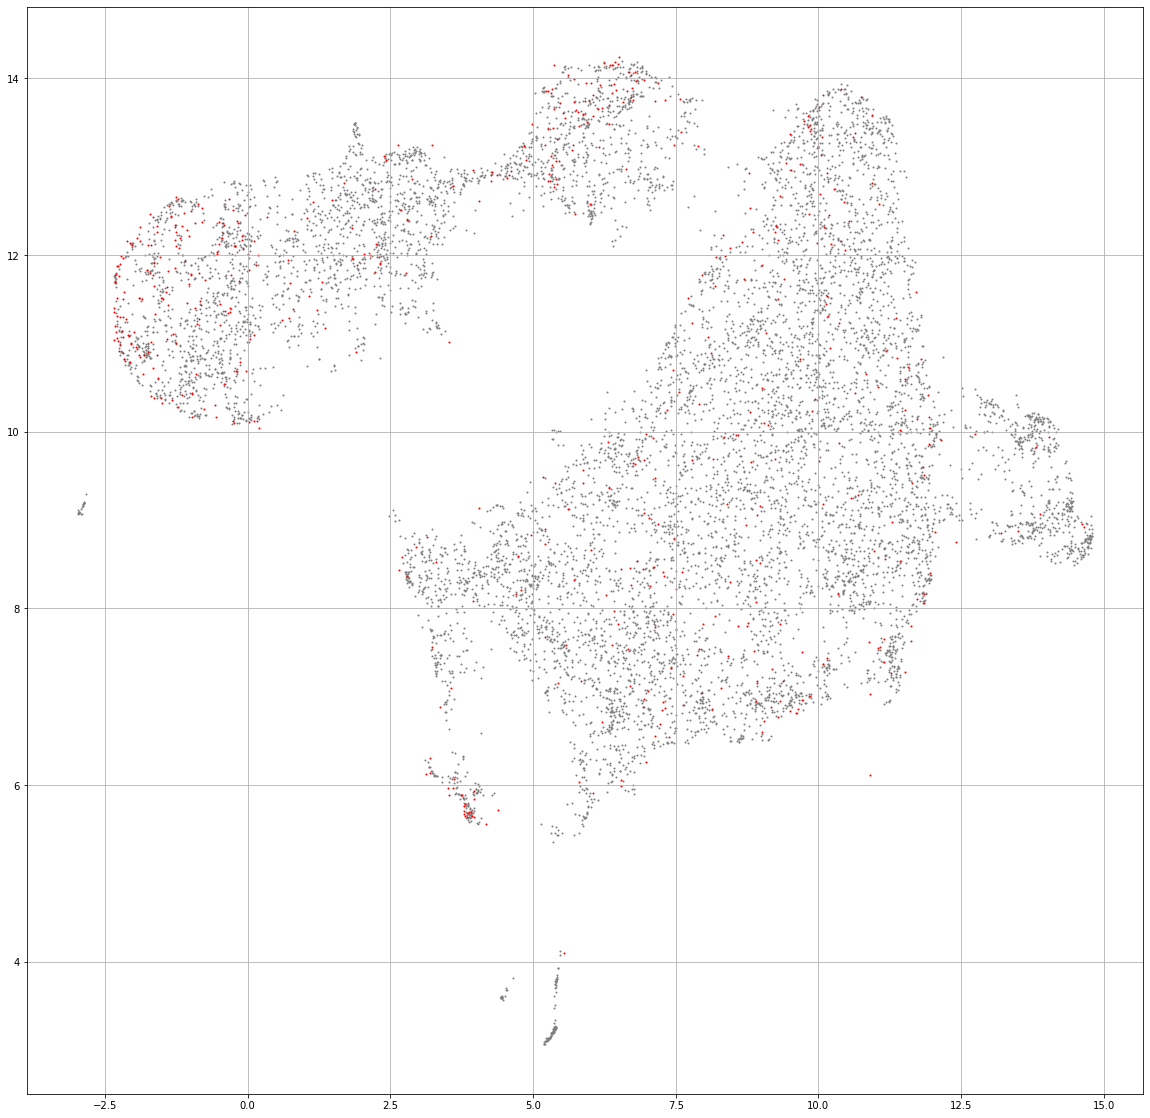

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.scatter(X.x0, X.x1, s=1, c='grey')
plt.scatter(my_X.x0, my_X.x1, s=1, c='red')
ax.grid(True)

In [26]:
cols = [i for i, _ in enumerate(my_X.index)]

In [27]:
hot_cmap = matplotlib.cm.get_cmap('hot')
norm = matplotlib.colors.Normalize(vmin=min(cols), vmax=max(cols))
hot_rgb = []
for i, _ in enumerate(my_X.index):
    k = matplotlib.colors.colorConverter.to_rgb(hot_cmap(norm(i)))
    hot_rgb.append(k)

In [31]:
fig = go.Figure(go.Scatter(
                 x=X.x0, 
                 y=X.x1,
                 mode='markers',
                 marker_color='grey',
                 text=X.index))

fig.add_trace(go.Scatter(x=my_X.x0, 
                         y=my_X.x1, 
                         mode="markers", 
                         marker=dict(
                            color='red'),
                         text=my_X.index))
plot(fig)

'temp-plot.html'

In [32]:
my_X.loc['Symphony X']

x0            10.069337
x1            13.341041
play_count    96.000000
Name: Symphony X, dtype: float64

In [34]:
my_X[my_X.index.str.contains('Williams')]

,x0,x1,play_count
artists,,,
Andrew Davis BBC Philharmonic Ralph Vaughan Williams Tasmin Little,-2.330202,11.690486,1
André Previn Itzhak Perlman John Williams Pittsburgh Symphony Orchestra,2.647722,8.433061,3
Anne-Sophie Mutter John Williams The Recording Arts Orchestra of Los Angeles,-1.150461,10.419966,13
Boston Pops Orchestra John Williams,-0.318298,11.405286,4
Carlos Gardel Itzhak Perlman John Williams Pittsburgh Symphony Orchestra,1.903140,10.902102,2
David Arnold John Williams Royal Philharmonic Orchestra,-0.197009,10.690360,1
Elmer Bernstein Itzhak Perlman John Williams Pittsburgh Symphony Orchestra,-1.962357,10.955254,1
Ennio Morricone Itzhak Perlman John Williams Pittsburgh Symphony Orchestra,-1.568472,10.609006,3
Itzhak Perlman Jeremy Lubbock John Williams Pittsburgh Symphony Orchestra Quincy Jones Rod Temperton,-0.824826,11.436280,1


In [36]:
X[X.index.str.contains('John Williams London Symphony Orchestra')]

,x0,x1
artists,,
John Williams London Symphony Orchestra,-1.188942,10.479839
